# AN IMAGE IS WORTH 16X16 WORDS:TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE
https://arxiv.org/pdf/2010.11929.pdf

## Preparation

In [1]:
import torch
import torchvision
print(f"torch version: {torch.__version__}" )
print(f"torchvision version: {torchvision.__version__}" )
    


torch version: 2.0.1
torchvision version: 0.15.2


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms



from torchinfo import summary
    
import data_setup 
import engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [16]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

##  Split data into patches and creating the class, position and patch embedding

In [17]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms : {manual_transforms}")

Manually created transforms : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [18]:
BATCH_SIZE = 32 #Original Paper has batch size of 4096 but obviously .....

train_dataloader , test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f8a97087b90>,
 ['pizza', 'steak', 'sushi'])

In [19]:
image_batch , label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape , label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

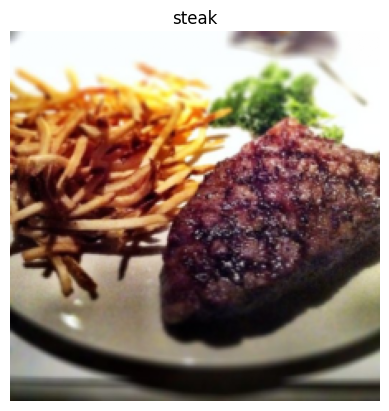

In [20]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [21]:
#examples

height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width) / patch_size**2)
print(f"Number of patches(N) with image height (H= {height}), width (W = {width}) and patch size (P= {patch_size}) : {number_of_patches}")

Number of patches(N) with image height (H= 224), width (W = 224) and patch size (P= 16) : 196


In [22]:
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### Turning a single image into patches


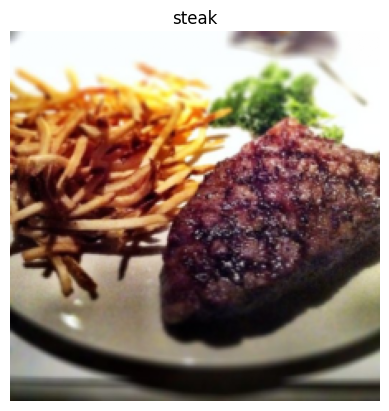

In [25]:
plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False);

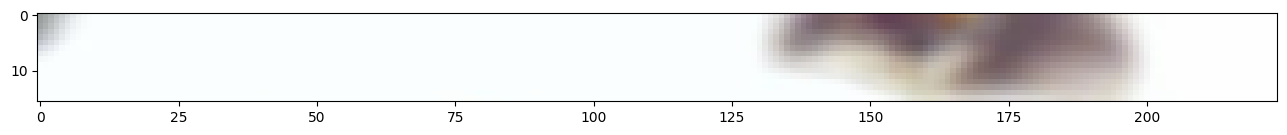

In [26]:
image_permuted = image.permute(1,2,0)

patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row : 14.0
Patch size: 16 pixels x 16 pixels


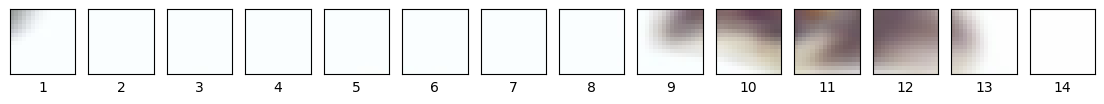

In [27]:
img_size = 224
patch_size = 16
num_patches = img_size/ patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row : {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(
    nrows = 1,
    ncols = img_size // patch_size,
    figsize = (num_patches, num_patches),
    sharex = True, 
    sharey = True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch: patch + patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row : 14.0         
Number of patches per column: 14.0         
Total patches: 2744.0         
Patch size: 16 pixels x 16 pixels


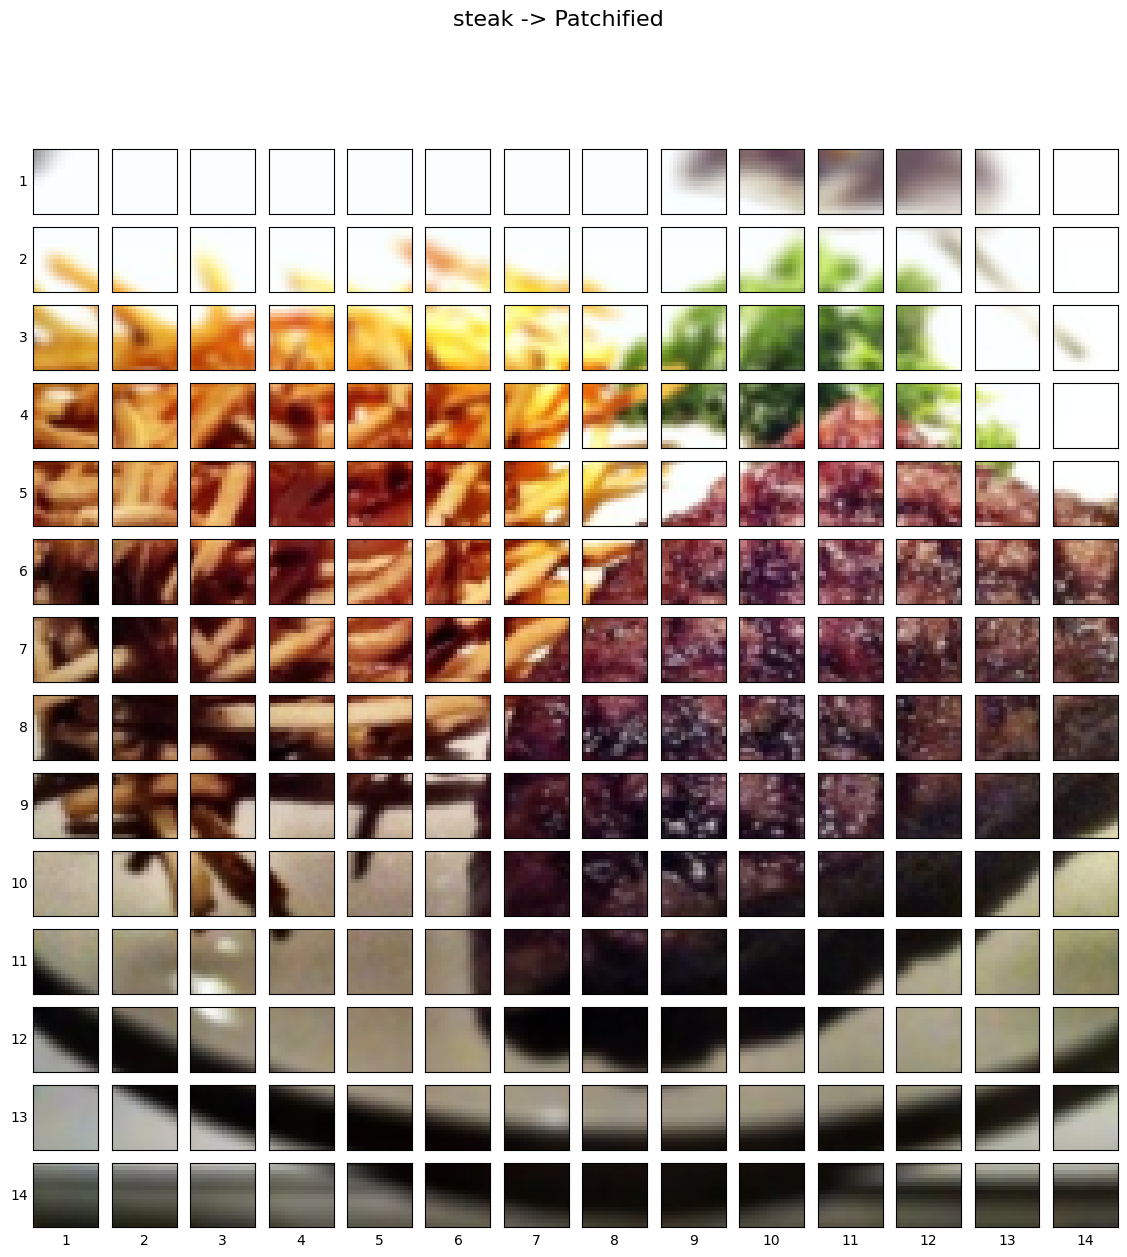

In [28]:
img_size = 224
patch_size = 16
num_patches = img_size/ patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row : {num_patches} \
        \nNumber of patches per column: {num_patches} \
        \nTotal patches: {num_patches*number_of_patches} \
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(
    nrows = img_size // patch_size,
    ncols = img_size // patch_size,
    figsize = (num_patches, num_patches),
    sharex = True, 
    sharey = True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size ,
                                      patch_width:patch_width+patch_size,
                                      :])
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### Creating image patches with torch.nn.Conv2d()

#### 1. Take a single image.
#### 2. Put in through the convolutional layer (conv2d) to turn the image into 2D feature maps (patch embeddings).
#### 3. Flatten the 2D feature map into a single sequence.

In [29]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768, 
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)

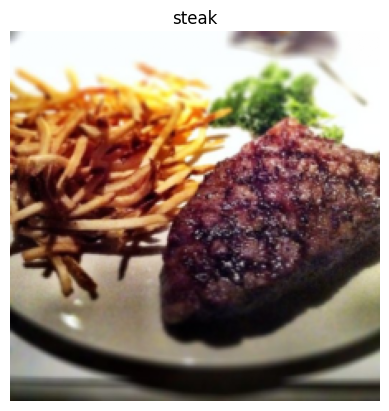

In [30]:
plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False);

In [31]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [430, 379, 465, 509, 95]


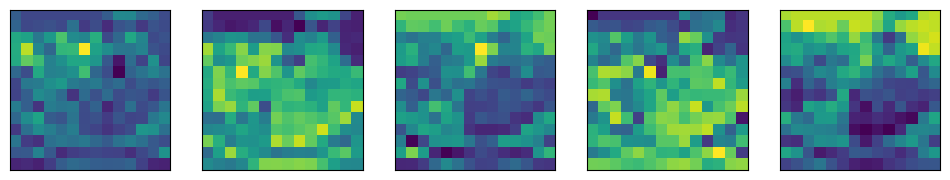

In [32]:
import random
random_indexes = random.sample(range(0, 758) , k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig , axs = plt.subplots(nrows =1 ,ncols = 5, figsize = (12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx,: , :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);


In [33]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.1378, -0.1327, -0.1326, -0.1327, -0.1330, -0.1319, -0.1327,
           -0.1322, -0.1181, -0.0631, -0.1211, -0.0331, -0.0463, -0.1293],
          [-0.1129, -0.0881, -0.1195, -0.1216, -0.1204, -0.0074, -0.1171,
           -0.1046, -0.1136, -0.1880, -0.0416, -0.1540, -0.0830, -0.1309],
          [-0.0154, -0.1036, -0.0685, -0.0235, -0.0062, -0.0332, -0.0302,
           -0.0474, -0.1820, -0.1431, -0.0656,  0.1005, -0.1266, -0.0713],
          [ 0.0196, -0.0306, -0.0965,  0.0537,  0.0477,  0.0138, -0.0840,
           -0.0105,  0.1683, -0.0879, -0.0890,  0.2416, -0.1106, -0.1296],
          [ 0.1667,  0.0493,  0.1762,  0.0440,  0.0501,  0.0303,  0.1780,
            0.0998, -0.1286,  0.0319,  0.0063, -0.0297, -0.0516, -0.1113],
          [ 0.0992, -0.0270, -0.0930,  0.0919,  0.0933,  0.1281, -0.0226,
           -0.0361, -0.0292, -0.0005,  0.1262,  0.0457,  0.0227,  0.0357],
          [ 0.1020, -0.0157, -0.1016, -0.0889,  0.0449,  0.0243, -0.1313,
           -0.0337, -0.0129, -0.

In [34]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")


Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [35]:
flatten = nn.Flatten(start_dim = 2,
                    end_dim = 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


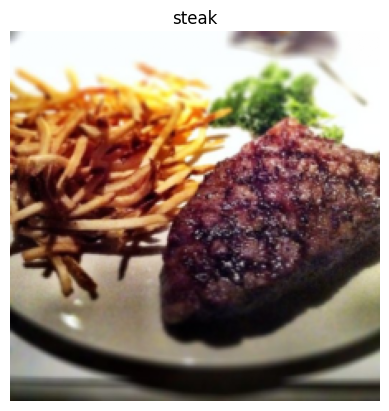

In [36]:
plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0)) 
print(f"Image feature map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [37]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")


Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


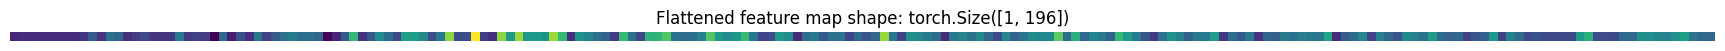

In [38]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] 

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [39]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape


(tensor([[-0.1378, -0.1327, -0.1326, -0.1327, -0.1330, -0.1319, -0.1327, -0.1322,
          -0.1181, -0.0631, -0.1211, -0.0331, -0.0463, -0.1293, -0.1129, -0.0881,
          -0.1195, -0.1216, -0.1204, -0.0074, -0.1171, -0.1046, -0.1136, -0.1880,
          -0.0416, -0.1540, -0.0830, -0.1309, -0.0154, -0.1036, -0.0685, -0.0235,
          -0.0062, -0.0332, -0.0302, -0.0474, -0.1820, -0.1431, -0.0656,  0.1005,
          -0.1266, -0.0713,  0.0196, -0.0306, -0.0965,  0.0537,  0.0477,  0.0138,
          -0.0840, -0.0105,  0.1683, -0.0879, -0.0890,  0.2416, -0.1106, -0.1296,
           0.1667,  0.0493,  0.1762,  0.0440,  0.0501,  0.0303,  0.1780,  0.0998,
          -0.1286,  0.0319,  0.0063, -0.0297, -0.0516, -0.1113,  0.0992, -0.0270,
          -0.0930,  0.0919,  0.0933,  0.1281, -0.0226, -0.0361, -0.0292, -0.0005,
           0.1262,  0.0457,  0.0227,  0.0357,  0.1020, -0.0157, -0.1016, -0.0889,
           0.0449,  0.0243, -0.1313, -0.0337, -0.0129, -0.0704, -0.0285, -0.0241,
          -0.099

### Turning the ViT patch embedding layer into a PyTorch module

In [40]:
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    
    def __init__(self,
                in_channels:int = 3,
                patch_size:int= 16,
                embedding_dim:int = 16):
        
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, 
                                    end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        return x_flattened.permute(0, 2, 1)
        

In [41]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [42]:
random_input_image = (1, 3, 224, 224)
summary(PatchEmbedding(), 
         input_size=random_input_image, 
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 16]         --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 16, 14, 14]      12,304               True
├─Flatten (flatten)                      [1, 16, 14, 14]      [1, 16, 196]         --                   --
Total params: 12,304
Trainable params: 12,304
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.41
Input size (MB): 0.60
Forward/backward pass size (MB): 0.03
Params size (MB): 0.05
Estimated Total Size (MB): 0.68

###  Creating the class token embedding

In [43]:
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-1.1008,  0.3551, -0.3230,  ...,  0.7766, -0.3768,  0.3731],
         [-1.0272,  0.2860, -0.2917,  ...,  0.7882, -0.4637,  0.3611],
         [-1.0270,  0.2856, -0.2913,  ...,  0.7881, -0.4635,  0.3615],
         ...,
         [-0.2346,  0.1342, -0.0314,  ...,  0.2784, -0.2585,  0.0547],
         [-0.1626,  0.0878,  0.0089,  ...,  0.3128, -0.3336,  0.0710],
         [-0.1500,  0.0798,  0.0042,  ...,  0.3076, -0.3259,  0.0807]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [44]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad = True)

print(class_token[:, :, :10])
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [45]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1)
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-1.1008,  0.3551, -0.3230,  ...,  0.7766, -0.3768,  0.3731],
         [-1.0272,  0.2860, -0.2917,  ...,  0.7882, -0.4637,  0.3611],
         ...,
         [-0.2346,  0.1342, -0.0314,  ...,  0.2784, -0.2585,  0.0547],
         [-0.1626,  0.0878,  0.0089,  ...,  0.3128, -0.3336,  0.0710],
         [-0.1500,  0.0798,  0.0042,  ...,  0.3076, -0.3259,  0.0807]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Creating the position embedding

In [46]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape


(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-1.1008,  0.3551, -0.3230,  ...,  0.7766, -0.3768,  0.3731],
          [-1.0272,  0.2860, -0.2917,  ...,  0.7882, -0.4637,  0.3611],
          ...,
          [-0.2346,  0.1342, -0.0314,  ...,  0.2784, -0.2585,  0.0547],
          [-0.1626,  0.0878,  0.0089,  ...,  0.3128, -0.3336,  0.0710],
          [-0.1500,  0.0798,  0.0042,  ...,  0.3076, -0.3259,  0.0807]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [47]:
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1,
                                            number_of_patches+1,
                                            embedding_dimension),
                                             requires_grad = True)

print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [48]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [-0.1008,  1.3551,  0.6770,  ...,  1.7766,  0.6232,  1.3731],
         [-0.0272,  1.2860,  0.7083,  ...,  1.7882,  0.5363,  1.3611],
         ...,
         [ 0.7654,  1.1342,  0.9686,  ...,  1.2784,  0.7415,  1.0547],
         [ 0.8374,  1.0878,  1.0089,  ...,  1.3128,  0.6664,  1.0710],
         [ 0.8500,  1.0798,  1.0042,  ...,  1.3076,  0.6741,  1.0807]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Putting it all together: from image to embedding

In [49]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                      patch_size= patch_size,
                                      embedding_dim = 768)

patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) 
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Multi-Head Attention (MSA)

### LayerNorm (LN) and Multi-Head Attention (MSA) layers

In [50]:
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block ("MSA block" for short).
    """
    
    def __init__(
        self, 
        embedding_dim:int =768,
        num_heads:int=12,
        attn_dropout:float = 0):
        
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim = embedding_dimension,
            num_heads = num_heads,
            dropout = attn_dropout,
            batch_first = True
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query = x,
            key = x,
            value = x,
            need_weights = False
        )
        
        return attn_output
        
    

In [51]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, 
                                                             num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## Multilayer Perceptron (MLP)

### LayerNorm (LN) and MLP (MSA) layers

In [52]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""

    def __init__(self,
                embedding_dim:int = 768,
                mlp_size:int = 3072,
                dropout:float = 0.1):
        
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim,
                     out_features= mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features = mlp_size,
                     out_features = embedding_dim),
            nn.Dropout(p= dropout)
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x

In [53]:
mlp_block = MLPBlock(embedding_dim=768, 
                     mlp_size=3072,
                     dropout=0.1) 

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## Transformer Encoder

In [54]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    
    def __init__(self, 
                embedding_dim:int = 768,
                num_heads:int = 12,
                mlp_size:int = 3072,
                mlp_dropout:float = 0.1,
                attn_dropout:float = 0):
        super().__init__()
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    def forward(self, x):
        
        x = self.msa_block(x) + x
        
        x = self.mlp_block(x) + x
        
        return x

In [55]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
         input_size=(1, 197, 768), 
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Creating a Transformer Encoder with PyTorch's Transformer layers

In [56]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                            nhead = 12,
                                                            dim_feedforward=3072,
                                                            dropout = 0.1,
                                                            activation = "gelu",
                                                            batch_first = True,
                                                            norm_first = True)
torch_transformer_encoder_layer


TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [58]:
summary(model=torch_transformer_encoder_layer,
         input_size=(1, 197, 768), 
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Putting it all together to create ViT

In [59]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    
    def __init__(self,
                img_size:int = 224,
                in_channels:int = 3,
                patch_size:int = 16,
                num_transformer_layers:int = 12,
                embedding_dim:int = 768,
                mlp_size:int = 3072,
                num_heads:int = 12,
                attn_dropout:float = 0,
                mlp_dropout:float = 0.1,
                embedding_dropout:float= 0.1,
                num_classes:int = 1000):   
        
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
        
    
    def forward(self, x):
        
        batch_size = x.shape[0]
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) 

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0]) 

        return x

In [60]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) 
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [61]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224) 
vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [62]:

from torchinfo import summary

summary(model=vit, 
         input_size=(32, 3, 224, 224), 
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]